# Bike Sharing Rebalancing Problem

The following implementation is derivated from the following paper: https://www.sciencedirect.com/science/article/abs/pii/S0305048313001187


## Introduction

| Variable Name  | Description |
| ------------- | ------------- |
| <i>V</i>   | Set of vertices |
| <i>A</i>   | Set of arcs  |
| <i>n</i>   | Number of stations |
| <i>m</i>   |  Number of vehicles  |
| <i>Q</i>   | Vehicle capacity |
| <i>q<sub>i</sub></i>  |  Demand at vertex i  |
| <i>c<sub>ij</sub></i>  |  Cost of arc (i,j)  |

In [1]:
#Importing cplex API
import sys
import docplex.cp

#Importing numpy and random generator
import numpy as np
rand = np.random

#Importing pyplot
import matplotlib.pyplot as plt

#Importing docplex model
from docplex.mp.model import Model
import itertools

In [2]:
#Initial values
n = 6                                          # amount of stations (Reggio-Emilia)
m = 2                                            # amount of vehicles
Q = 10                                           # vehicles capacity
end = n + 1
Vo = [i for i in range(1, n+1)] # stations without starting and ending deposit   
V = [0] + Vo + [end] 
#A = [(i, j) for i in V for j in V]           # edges A_tilde
A_tilde = [(i, j) for i in V for j in V]  
q = {i: rand.randint(-Q, Q) for i in V}           # demand along edges
Qtot = sum(q.values())



In [3]:
# Generating random coordinates and computing the distances using euclidian distance
coord = rand.rand(len(V), 2) * 500
c = {(i, j): 
        float('Inf') if i == n or j == n  else np.hypot(coord[i][0]-coord[j][0], coord[i][1]-coord[j][1]) 
             for i, j in A_tilde}       


(49.678219719962215, 517.3711038734538, 102.35613781988991, 362.39111495538316)

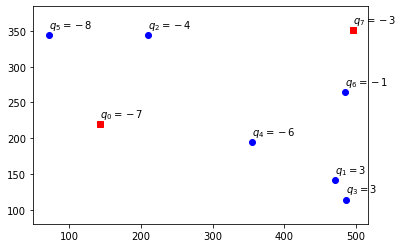

In [4]:
for point in coord[1:]:   
    plt.scatter(point[0], point[1], c='b')

for i in V:
    plt.annotate('$q_%d=%d$' % (i, q[i]), (coord[i][0], coord[i][1]+10))

plt.plot(coord[0][0], coord[0][1], c='r', marker='s') #marker=(5, 1)
plt.plot(coord[end][0], coord[end][1], c='r', marker='s') 
plt.axis('equal')

In [5]:
# Model
f4 = Model('Formulation-F4')

# Decision variables
x = f4.binary_var_dict(A_tilde, name='x')
f = f4.continuous_var_dict(A_tilde, name='f')
g = f4.continuous_var_dict(A_tilde, name='g')

In [6]:
sys.path

['C:\\Users\\Giaco\\Desktop\\DS Project\\Bike-sharing-rebalancing-problem',
 'C:\\Program Files\\IBM\\ILOG\\CPLEX_Studio_Community129\\cplex\\python\\3.7\\x64_win64',
 'c:\\python3.7\\python37.zip',
 'c:\\python3.7\\DLLs',
 'c:\\python3.7\\lib',
 'c:\\python3.7',
 '',
 'c:\\python3.7\\lib\\site-packages',
 'c:\\python3.7\\lib\\site-packages\\certifi-2017.7.27.1-py3.7.egg',
 'c:\\python3.7\\lib\\site-packages\\chardet-3.0.4-py3.7.egg',
 'c:\\python3.7\\lib\\site-packages\\idna-2.6-py3.7.egg',
 'c:\\python3.7\\lib\\site-packages\\urllib3-1.22-py3.7.egg',
 'c:\\python3.7\\lib\\site-packages\\docloud-1.0.257-py3.7.egg',
 'c:\\python3.7\\lib\\site-packages\\win32',
 'c:\\python3.7\\lib\\site-packages\\win32\\lib',
 'c:\\python3.7\\lib\\site-packages\\Pythonwin',
 'c:\\python3.7\\lib\\site-packages\\IPython\\extensions',
 'C:\\Users\\Giaco\\.ipython']

In [8]:
#Function to minimize
f4.minimize(f4.sum(c[i, j]*x[i, j] for i in V for j in V))

#Constraints
f4.add_constraints(f4.sum(x[i, j] for i in V) == 1 for j in Vo) #17

f4.add_constraints(f4.sum(x[j, i] for i in V) == 1 for j in Vo) #18

f4.add_constraint(f4.sum(x[0, j] for j in V) <= m ) #19

f4.add_constraint(f4.sum(x[0, j] for j in Vo) == f4.sum(x[i, n-1] for i in Vo)) #20

for i in range(1, len(Vo) + 1):
    for S in itertools.permutations(Vo, i):
        f4.add_constraint(f4.sum(x[i, j] for j in S for i in S) <= len(S)-1) # 21
        
f4.add_constraints((f[i,j] + g[j,i]) == Q * x[i,j] for i in V for j in V)       #22
f4.add_constraints((f4.sum((f[j, i] - g[i,j]) for i in V) - f4.sum((f[i, j] - g[j,i]) for i in V)) == 2*q[j] for j in Vo) #23
f4.add_constraint(f4.sum(f[0,j] for j in Vo) >= f4.max(0, -Qtot)) #24
f4.add_constraint(f4.sum(f[j,end] for j in Vo) >= f4.max(0, Qtot)) #25

f4.add_constraint((f4.sum(g[j,0] for j in Vo) <= min(m*Q, m*Q + Qtot)))                   #26
f4.add_constraints((max(0,q[i],-q[j]) * x[i,j]) <= f[i,j] for i in V for j in V)                   #27_1
f4.add_constraints(f[i,j] <= (min(Q,Q + q[i],Q -q[j]) * x[i,j])  for i in V for j in V)                   #27_2
f4.add_constraints(((Q - min(Q, Q + q[i], Q - q[j])) * x[i,j]) <= g[i,j] for i in V for j in V)                 #28_1
f4.add_constraints(g[i,j] <= ((Q - max(0, q[i], - q[j])) * x[i,j])  for i in V for j in V)                   #28_2

solutionF4 = f4.solve(log_output=True)

CPLEX Error  1016: Community Edition. Problem size limits exceeded. Purchase at https://ibm.co/2s0wqSa.
CPLEX Error  1217: No solution exists.
CPLEX Error  1217: No solution exists.


DOcplexLimitsExceeded: **** Promotional version. Problem size limits exceeded, CPLEX code=1016

In [ ]:
print(solutionF4)


In [ ]:
print(solutionF4.solve_details)


In [ ]:
active_arcs = [a for a in A if x[a].solution_value > 0.9]
plt.scatter(loc_x[1:], loc_y[1:], c='b')
for i in V:
    plt.annotate('$q_%d=%d$' % (i, q[i]), (loc_x[i]+2, loc_y[i]))
for i, j in active_arcs:
    plt.plot([loc_x[i], loc_x[j]], [loc_y[i], loc_y[j]], c='g', alpha=0.3)
plt.plot(loc_x[0], loc_y[0], c='r', marker='s')
plt.axis('equal')